In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from nltk.corpus import stopwords
import re
# from wordcloud import WordCloud
# conda install -c conda-forge wordcloud=1.2.1

In [2]:
# load the data
data = pd.read_csv("Tweets_source_data.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# first model

In [3]:
# setting up our version of stopwords
airlines = data['airline']

# plus classic English stopwords
stop = stopwords.words('english')

In [4]:
#extracting only words, other than digits and airline names
def preprocessor(text):
    words = text.split()
    del words[0]
    words = [re.sub('[^0-9a-zA-Z]+', '', w.replace('#','').lower()) for w in words if not w.startswith('http') and not w.startswith('@')]
    finalwords = [w for w in words if (not w.isdigit()  and w not in stop and w not in airlines)]
    return ' '.join(finalwords)

In [5]:
#print(data.head(3))
data = data.loc[:14640,['text','airline_sentiment']]
data['text'] = data['text'].apply(preprocessor)

print(preprocessor("Delta flight #450 from Austin is the worst #twitter #help @marekz"))


flight austin worst twitter help


In [6]:
# Split the data into training and testing

y = data['airline_sentiment']
X = data['text']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [7]:
# extracting the feature list
from sklearn.feature_extraction.text import CountVectorizer

# tranforming the feature list
from sklearn.feature_extraction.text import TfidfTransformer

# training
from sklearn.naive_bayes import MultinomialNB

# implement pipeline
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect',CountVectorizer(ngram_range=(2,3))),('tfidf',TfidfTransformer()),('clf',MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)

print('Test Accuracy: %.3f' % text_clf.score(X_test, y_test))

Test Accuracy: 0.665


# 2nd model

- needs more work; didn't get to debug it yet

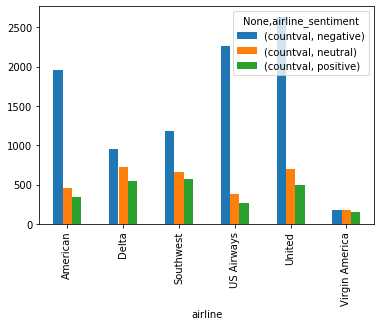

In [8]:
# Check the ratio of positive and negative tweets for each airline
#import seaborn as sns
data = pd.read_csv("Tweets_source_data.csv")

data['countval']=1
groupby_object=data[['airline','airline_sentiment','countval']].groupby(['airline','airline_sentiment']).aggregate(sum)
groupby_object.unstack(level=1).plot(kind='bar')


# #*******added*******
# groupby_object.reset_index(inplace=True)
# #sns.barplot(x='airline', y='countval', data=groupby_object)
# sns.catplot(x="airline", y="countval", hue="airline_sentiment", data=groupby_object,
#                 height=6, kind="bar", palette="muted")
# plt.xlabel('Airlines')
# #plt.yscale('log')
# plt.ylabel('Sentiment Counts')
# # plt.legend(['negative', 'neutral', 'positive'], loc='best', fontsize='small', fancybox=True)
# plt.title(label='Sentimental Analysis by Airlines')
#plt.show()
# data.head()
#groupby_object.head()

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
# import nltk
# nltk.download('stopwords')


#####
data['text']=data['text'].map(lambda x: re.sub("^@[^\s]+\s","",x))
def getHashtag(x):
	g=re.match("^[^#]+#([^\s]+).*",x)
	if g:
		return g.group(1)
	else:
		return ""
	
data['hashtags']=data['text'].map(getHashtag)
# Convert to lower case
data['hashtags']=data['hashtags'].str.lower() 

from nltk.corpus import stopwords
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = raw_review
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

Reviews=[]
dataPos=data[data['airline_sentiment']=='positive']
for i in range(0, len(dataPos)):
    Reviews.append(review_to_words(dataPos['text'].tolist()[i]))

vect = TfidfVectorizer(sublinear_tf=True, max_df=0.5, analyzer='word',stop_words='english')
vect.fit(Reviews)
idf = vect._tfidf.idf_
wordDict=dict(zip(vect.get_feature_names(), idf))

In [10]:
word1={k: v for k, v in wordDict.items() if v < 4}
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(word1.keys()))
plt.title('POSITIVE : TFID FREQ < 4')
plt.imshow(wordcloud)

ModuleNotFoundError: No module named 'wordcloud'